In [32]:
import numpy as np
import pandas as pd
import warnings
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from scipy.integrate import ODEintWarning

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.usetex'] = True

viridis_pal = sns.color_palette('viridis', n_colors=8)
rocket_pal = sns.color_palette('rocket', n_colors=3)

In [2]:
def modelLV(X, t, params):
    a1, a2, a3, a4, a5, a6, a7, a8, a9 = params
    X1, X2, X3 = X

    # Prevent negative or huge values
    X1 = np.clip(X1, 0, 1e6)
    X2 = np.clip(X2, 0, 1e6)
    X3 = np.clip(X3, 0, 1e6)
    
    dX1 = - a1*X1 - a2*X1*X2 + a3*X1*X3
    dX2 = a4*X1*X2 - a5*X2 - a6*X2*X3
    dX3 = -a7*X1*X3 + a8*X2*X3 - a9*X3
    
    return [dX1, dX2, dX3]

### Ground Truth Solution

In [3]:
# Ground truth values
a1 = 0.18
a2 = 0.16 
a3 = 0.15 
a4 = 0.11 
a5 = 0.02 
a6 = 0.12 
a7 = 0.04 
a8 = 0.12 
a9 = 0.02

groundParams = np.array([a1, a2, a3, a4, a5, a6, a7, a8, a9])

In [4]:
# Initial conditions
X0 = [4, 2, 1]

t = np.linspace(0, 80, 161)

sol = odeint(modelLV, X0, t, args=(groundParams,))

X1_g = sol[:,0]
X2_g = sol[:,1]
X3_g = sol[:,2]

## Generating synthetic data

In [5]:
def addNoise(df, std=0.05, samples=5):
    # Repeat each row 'samples' times
    df_expanded = df.loc[df.index.repeat(samples)].reset_index(drop=True)

    # Apply log-normal transformation
    # for col in ['X1', 'X2', 'X3']:
    for col in ['X1']:
        df_expanded[col] = np.random.lognormal(np.log(df_expanded[col]), std)

    return df_expanded

In [6]:
# dfNoise_low.to_csv('test/X1_noise_low.csv', index=False, float_format='%.2f')
# dfNoise_medium.to_csv('test/X1_noise_medium.csv', index=False, float_format='%.2f')
# dfNoise_high.to_csv('test/X1_noise_high.csv', index=False, float_format='%.2f')

dfNoise_low = pd.read_csv('test/X1_noise_low.csv')
dfNoise_medium = pd.read_csv('test/X1_noise_medium.csv')
dfNoise_high = pd.read_csv('test/X1_noise_high.csv')

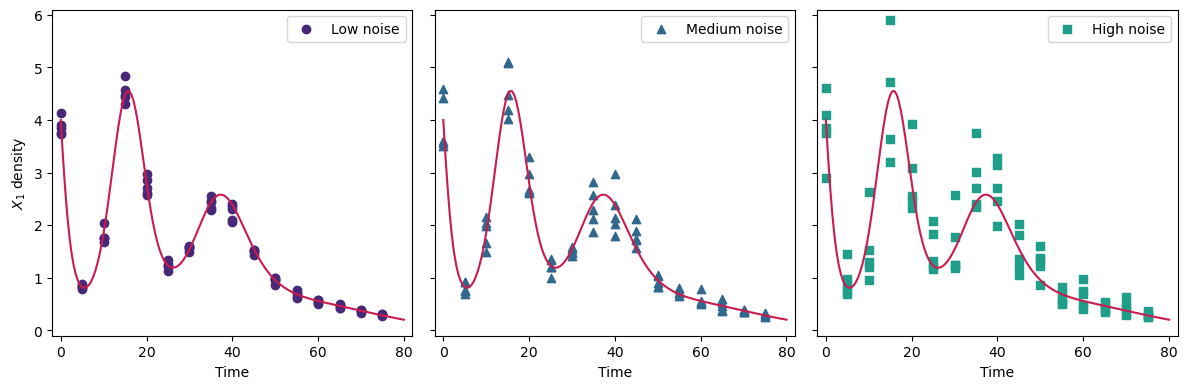

In [30]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4), sharey=True)

axs[0].scatter(x=dfNoise_low['Time'], y=dfNoise_low['X1'], color=viridis_pal[0], marker="o", label='Low noise')
axs[1].scatter(x=dfNoise_medium['Time'], y=dfNoise_medium['X1'], color=viridis_pal[2], marker="^", label='Medium noise')
axs[2].scatter(x=dfNoise_high['Time'], y=dfNoise_high['X1'], color=viridis_pal[4], marker="s", label='High noise')

axs[0].plot(t, X1_g, lw=1.5, color=rocket_pal[1])
axs[1].plot(t, X1_g, lw=1.5, color=rocket_pal[1])
axs[2].plot(t, X1_g, lw=1.5, color=rocket_pal[1])

axs[0].set_ylabel('$X_1$ density')

for i in range(3):
    axs[i].set_xlabel('Time')
    axs[i].set_xlim(-2, 82)
    axs[i].set_ylim((-0.1,6.1))
    axs[i].legend()

plt.tight_layout()

plt.show()

In [9]:
# Load windows 
dfWindows = pd.read_csv('cycle/qualX3cell.csv')

## Cost function

In [10]:
def rss(data_A, interp_func):
    try:
        times = data_A[:, 0]
        obs = data_A[:, 1]

        # Find unique times and how many replicates there are per time
        unique_times, counts = np.unique(times, return_counts=True)

        # Interpolate model at unique time points
        model_values = interp_func(unique_times)

        # Repeat to match number of replicates
        model_repeated = np.repeat(model_values, counts)

        diff = obs - model_repeated
        if not np.all(np.isfinite(diff)):
            return 1e6

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", RuntimeWarning)
            rss = np.sum(diff ** 2)

        if not np.isfinite(rss):
            return 1e6
        
        return rss

    except Exception:
        return 1e6

In [11]:
def costFunction(params, model, data_A, windows=None, use_windows=True,
                  num_variables=3, rss_variable=0, window_variable=2, penalty_value=1e6):
    try:
        # Initial conditions
        X0 = [4, 2, 1]

        # Time range
        t_max_A = np.max(data_A[:, 0])
        if use_windows and windows is not None:
            t_max = max(t_max_A, np.max(windows[:, 1]))
        else:
            t_max = t_max_A

        t_eval = np.linspace(0, t_max, 1000)

        # Solve ODE model
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", ODEintWarning)
            warnings.simplefilter("ignore", RuntimeWarning)
            sol = odeint(model, X0, t_eval, args=(params,))

        if not np.all(np.isfinite(sol)):
            return penalty_value * np.random.uniform(1, 2)

        # Window constraint check
        if use_windows and windows is not None:
            var_w = sol[:, window_variable]
            for row in windows:
                tmin, tmax, vmin, vmax = row
                mask = (t_eval >= tmin) & (t_eval <= tmax)
                if not np.any((var_w[mask] >= vmin) & (var_w[mask] <= vmax)):
                    return penalty_value * np.random.uniform(1, 2)

        # RSS computation
        var_rss = sol[:, rss_variable]
        interp_func = interp1d(t_eval, var_rss, kind='linear', bounds_error=False, fill_value='extrapolate')
        return rss(data_A, interp_func)

    except Exception:
        return penalty_value * np.random.uniform(1, 2)

In [13]:
# Compute cost using ground truth
cost = costFunction(
    params=groundParams,
    model=modelLV,          # model function
    data_A=dfNoise_low.values,      # dataset A
    windows=dfWindows.values,    # window constraints
    use_windows=False,            # or False to use only RSS
    num_variables=3,
    rss_variable=0,
    window_variable=2,
    penalty_value=1e6
)

print(f"Total cost: {cost}")

Total cost: 0.914371125069513


## Optimization

In [14]:
# Define parameter bounds in the specified order
bounds = [
    (5e-2, 5e-1),  # a1
    (5e-2, 5e-1),  # a2
    (5e-2, 5e-1),  # a3
    (5e-2, 5e-1),  # a4
    (1e-2, 1e-1),  # a5
    (5e-2, 5e-1),  # a6
    (1e-2, 1e-1),  # a7
    (5e-2, 5e-1),  # a8
    (1e-2, 1e-1),  # a9
]

In [15]:
from scipy.optimize import differential_evolution

### Low noise

In [17]:
%%time

def objective(params):
    return costFunction(
        params=params,
        model=modelLV,
        data_A=dfNoise_low.values,
        windows=dfWindows.values,
        use_windows=False,
        num_variables=3,
        rss_variable=0,
        window_variable=2,
        penalty_value=1e6
    )

result = differential_evolution(
    func=objective,
    bounds=bounds,
    strategy='rand1bin',
    maxiter=5000,
    popsize=20,
    tol=1e-6,
    mutation=0.8,
    recombination=0.8,
    polish=True,
    workers=-1,
    updating='deferred',
    disp=False
)

bestParams = result.x
cost = result.fun

print("Optimized parameters:", bestParams)
print("Final cost:", cost)

bestParams_noWin_low = bestParams

Optimized parameters: [0.05       0.25702672 0.17125934 0.07833359 0.0603676  0.07686798
 0.03317196 0.15022    0.08429234]
Final cost: 0.773747873471405
CPU times: user 1min 10s, sys: 13.2 s, total: 1min 23s
Wall time: 28min 31s


In [18]:
%%time

def objective(params):
    return costFunction(
        params=params,
        model=modelLV,
        data_A=dfNoise_low.values,
        windows=dfWindows.values,
        use_windows=True,
        num_variables=3,
        rss_variable=0,
        window_variable=2,
        penalty_value=1e6
    )

result = differential_evolution(
    func=objective,
    bounds=bounds,
    strategy='rand1bin',
    maxiter=5000,
    popsize=20,
    tol=1e-6,
    mutation=0.8,
    recombination=0.8,
    polish=True,
    workers=-1,
    updating='deferred',
    disp=False
)

bestParams = result.x
cost = result.fun

print("Optimized parameters:", bestParams)
print("Final cost:", cost)

bestParams_win_low = bestParams

Optimized parameters: [0.14489451 0.20851646 0.13594689 0.13092958 0.07626875 0.11263068
 0.03568756 0.14100504 0.02896532]
Final cost: 0.9709071877753415
CPU times: user 1min 6s, sys: 12.7 s, total: 1min 19s
Wall time: 28min 18s


In [20]:
# Change this cell to a code cell to save or load data from a file.

# Save parameters
np.savetxt("test/bestParams_noWin_low.csv", bestParams_noWin_low, delimiter=",", header="a1,a2,a3,a4,a5,a6,a7,a8,a9")
np.savetxt("test/bestParams_win_low.csv", bestParams_win_low, delimiter=",", header="a1,a2,a3,a4,a5,a6,a7,a8,a9")

# Load parameters
bestParams_noWin_low = np.loadtxt("test/bestParams_noWin_low.csv", delimiter=",", skiprows=1)
bestParams_win_low = np.loadtxt("test/bestParams_win_low.csv", delimiter=",", skiprows=1)

### Medium noise

In [21]:
%%time

def objective(params):
    return costFunction(
        params=params,
        model=modelLV,
        data_A=dfNoise_medium.values,
        windows=dfWindows.values,
        use_windows=False,
        num_variables=3,
        rss_variable=0,
        window_variable=2,
        penalty_value=1e6
    )

result = differential_evolution(
    func=objective,
    bounds=bounds,
    strategy='rand1bin',
    maxiter=5000,
    popsize=20,
    tol=1e-6,
    mutation=0.8,
    recombination=0.8,
    polish=True,
    workers=-1,
    updating='deferred',
    disp=False
)

bestParams = result.x
cost = result.fun

print("Optimized parameters:", bestParams)
print("Final cost:", cost)

bestParams_noWin_medium = bestParams

Optimized parameters: [0.06407699 0.27848722 0.18349921 0.09906669 0.07447812 0.11304452
 0.02408885 0.13568748 0.06564113]
Final cost: 4.9640348090786945
CPU times: user 1min 6s, sys: 12.4 s, total: 1min 18s
Wall time: 27min 59s


In [22]:
%%time

def objective(params):
    return costFunction(
        params=params,
        model=modelLV,
        data_A=dfNoise_medium.values,
        windows=dfWindows.values,
        use_windows=True,
        num_variables=3,
        rss_variable=0,
        window_variable=2,
        penalty_value=1e6
    )

result = differential_evolution(
    func=objective,
    bounds=bounds,
    strategy='rand1bin',
    maxiter=5000,
    popsize=20,
    tol=1e-6,
    mutation=0.8,
    recombination=0.8,
    polish=True,
    workers=-1,
    updating='deferred',
    disp=False
)

bestParams = result.x
cost = result.fun

print("Optimized parameters:", bestParams)
print("Final cost:", cost)

bestParams_win_medium = bestParams

Optimized parameters: [0.11785868 0.23507407 0.1219896  0.16385432 0.06424555 0.16345767
 0.02512377 0.15579087 0.04017613]
Final cost: 5.732160709622592
CPU times: user 1min 1s, sys: 12.2 s, total: 1min 14s
Wall time: 27min 42s


In [23]:
# Change this cell to a code cell to save or load data from a file.

# Save parameters
np.savetxt("test/bestParams_noWin_medium.csv", bestParams_noWin_medium, delimiter=",", header="a1,a2,a3,a4,a5,a6,a7,a8,a9")
np.savetxt("test/bestParams_win_medium.csv", bestParams_win_medium, delimiter=",", header="a1,a2,a3,a4,a5,a6,a7,a8,a9")

# Load parameters
bestParams_noWin_medium = np.loadtxt("test/bestParams_noWin_medium.csv", delimiter=",", skiprows=1)
bestParams_win_medium = np.loadtxt("test/bestParams_win_medium.csv", delimiter=",", skiprows=1)

### High noise

In [24]:
%%time

def objective(params):
    return costFunction(
        params=params,
        model=modelLV,
        data_A=dfNoise_high.values,
        windows=dfWindows.values,
        use_windows=False,
        num_variables=3,
        rss_variable=0,
        window_variable=2,
        penalty_value=1e6
    )

result = differential_evolution(
    func=objective,
    bounds=bounds,
    strategy='rand1bin',
    maxiter=5000,
    popsize=20,
    tol=1e-6,
    mutation=0.8,
    recombination=0.8,
    polish=True,
    workers=-1,
    updating='deferred',
    disp=False
)

bestParams = result.x
cost = result.fun

print("Optimized parameters:", bestParams)
print("Final cost:", cost)

bestParams_noWin_high = bestParams

Optimized parameters: [0.21341022 0.22136117 0.24814645 0.06396691 0.07334    0.06115691
 0.03899078 0.11144942 0.01958952]
Final cost: 30.272757505889594
CPU times: user 1min 5s, sys: 12.2 s, total: 1min 17s
Wall time: 31min 22s


In [25]:
%%time

def objective(params):
    return costFunction(
        params=params,
        model=modelLV,
        data_A=dfNoise_high.values,
        windows=dfWindows.values,
        use_windows=True,
        num_variables=3,
        rss_variable=0,
        window_variable=2,
        penalty_value=1e6
    )

result = differential_evolution(
    func=objective,
    bounds=bounds,
    strategy='rand1bin',
    maxiter=5000,
    popsize=20,
    tol=1e-6,
    mutation=0.8,
    recombination=0.8,
    polish=True,
    workers=-1,
    updating='deferred',
    disp=False
)

bestParams = result.x
cost = result.fun

print("Optimized parameters:", bestParams)
print("Final cost:", cost)

bestParams_win_high = bestParams

Optimized parameters: [0.12217309 0.24895469 0.15384951 0.0875914  0.09969315 0.05998125
 0.03916674 0.1528872  0.04287727]
Final cost: 31.226717028973635
CPU times: user 1min 3s, sys: 12.4 s, total: 1min 15s
Wall time: 29min 45s


In [26]:
# Change this cell to a code cell to save or load data from a file.

# Save parameters
np.savetxt("test/bestParams_noWin_high.csv", bestParams_noWin_high, delimiter=",", header="a1,a2,a3,a4,a5,a6,a7,a8,a9")
np.savetxt("test/bestParams_win_high.csv", bestParams_win_high, delimiter=",", header="a1,a2,a3,a4,a5,a6,a7,a8,a9")

# Load parameters
bestParams_noWin_high = np.loadtxt("test/bestParams_noWin_high.csv", delimiter=",", skiprows=1)
bestParams_win_high = np.loadtxt("test/bestParams_win_high.csv", delimiter=",", skiprows=1)

### Plotting

In [27]:
# Solve model using optimized parameters
t = np.linspace(0, 80, 161)

# Low noise
solution = odeint(modelLV, X0, t, args=(bestParams_noWin_low,))
X1_noWin_low, X2_noWin_low, X3_noWin_low = solution.T

solution = odeint(modelLV, X0, t, args=(bestParams_win_low,))
X1_win_low, X2_win_low, X3_win_low = solution.T

# Medium noise
solution = odeint(modelLV, X0, t, args=(bestParams_noWin_medium,))
X1_noWin_medium, X2_noWin_medium, X3_noWin_medium = solution.T

solution = odeint(modelLV, X0, t, args=(bestParams_win_medium,))
X1_win_medium, X2_win_medium, X3_win_medium = solution.T

# High noise
solution = odeint(modelLV, X0, t, args=(bestParams_noWin_high,))
X1_noWin_high, X2_noWin_high, X3_noWin_high = solution.T

solution = odeint(modelLV, X0, t, args=(bestParams_win_high,))
X1_win_high, X2_win_high, X3_win_high = solution.T

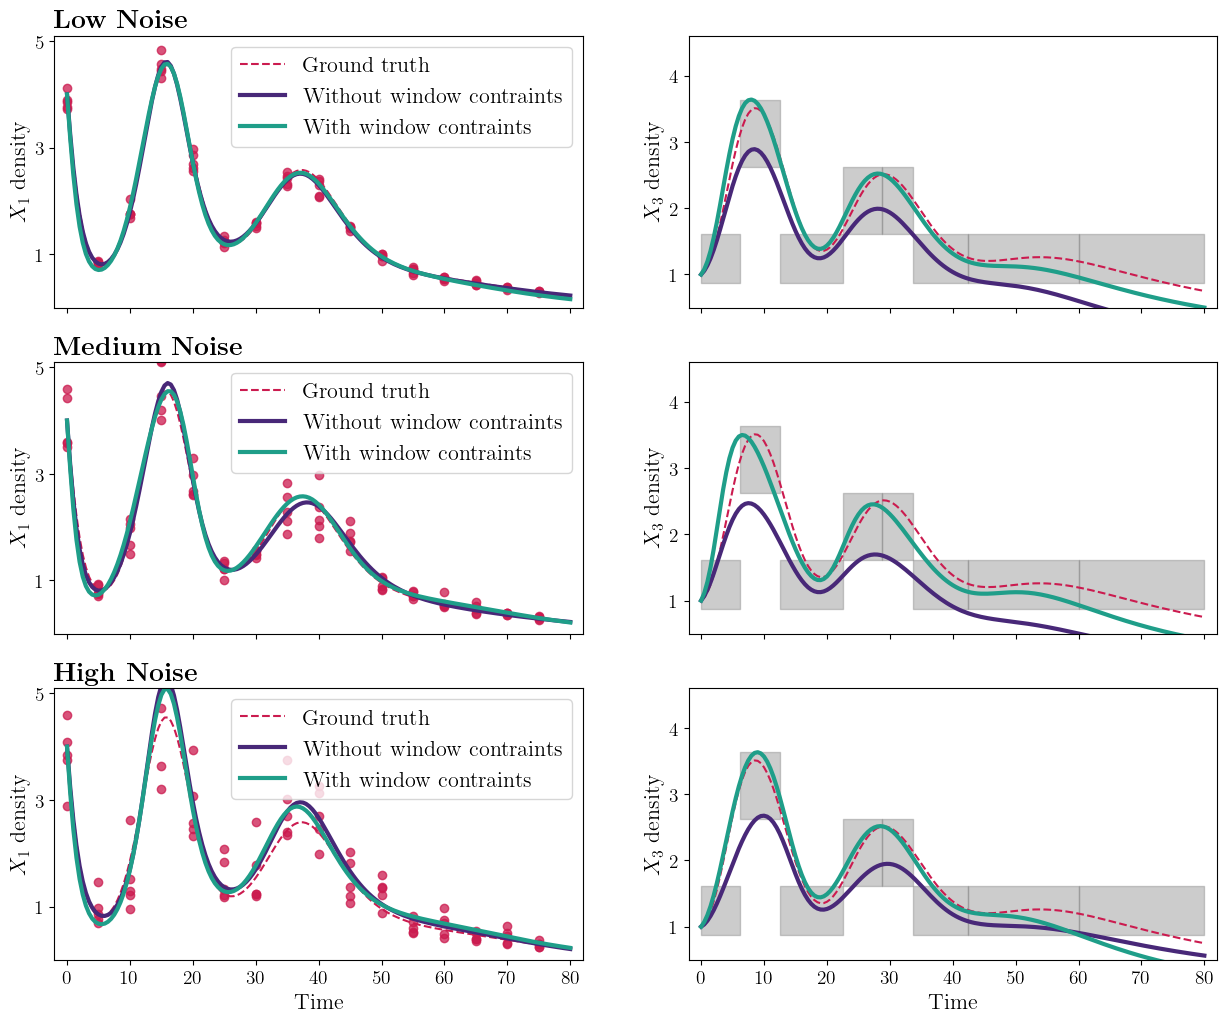

In [34]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15,12), sharex=True)

# Row 1: Low Noise
ax[0,0].set_title(r'\bf{Low Noise}', loc='left')
ax[0,0].scatter(x=dfNoise_low['Time'], y=dfNoise_low['X1'], color=rocket_pal[1], marker="o", alpha=0.75)
ax[0,0].plot(t, X1_g, lw=1.5, color=rocket_pal[1], ls='--', label='Ground truth')
ax[0,0].plot(t, X1_noWin_low, lw=3, color=viridis_pal[0], label='Without window contraints')
ax[0,0].plot(t, X1_win_low, lw=3, color=viridis_pal[4], label='With window contraints')
ax[0,0].legend()


ax[0,1].plot(t, X3_g, lw=1.5, color=rocket_pal[1], ls='--')
ax[0,1].plot(t, X3_noWin_low, lw=3, color=viridis_pal[0], label='Without window contraints')
ax[0,1].plot(t, X3_win_low, lw=3, color=viridis_pal[4], label='With window contraints')

# Row 2: Medium Noise
ax[1,0].set_title(r'\bf{Medium Noise}', loc='left')
ax[1,0].scatter(x=dfNoise_medium['Time'], y=dfNoise_medium['X1'], color=rocket_pal[1], marker="o", alpha=0.75)
ax[1,0].plot(t, X1_g, lw=1.5, color=rocket_pal[1], ls='--', label='Ground truth')
ax[1,0].plot(t, X1_noWin_medium, lw=3, color=viridis_pal[0], label='Without window contraints')
ax[1,0].plot(t, X1_win_medium, lw=3, color=viridis_pal[4], label='With window contraints')
ax[1,0].legend()


ax[1,1].plot(t, X3_g, lw=1.5, color=rocket_pal[1], ls='--')
ax[1,1].plot(t, X3_noWin_medium, lw=3, color=viridis_pal[0], label='Without window contraints')
ax[1,1].plot(t, X3_win_medium, lw=3, color=viridis_pal[4], label='With window contraints')

# Row 3: High Noise
ax[2,0].set_title(r'\bf{High Noise}', loc='left')
ax[2,0].scatter(x=dfNoise_high['Time'], y=dfNoise_high['X1'], color=rocket_pal[1], marker="o", alpha=0.75)
ax[2,0].plot(t, X1_g, lw=1.5, color=rocket_pal[1], ls='--', label='Ground truth')
ax[2,0].plot(t, X1_noWin_high, lw=3, color=viridis_pal[0], label='Without window contraints')
ax[2,0].plot(t, X1_win_high, lw=3, color=viridis_pal[4], label='With window contraints')
ax[2,0].legend()


ax[2,1].plot(t, X3_g, lw=1.5, color=rocket_pal[1], ls='--')
ax[2,1].plot(t, X3_noWin_high, lw=3, color=viridis_pal[0], label='Without window contraints')
ax[2,1].plot(t, X3_win_high, lw=3, color=viridis_pal[4], label='With window contraints')

# Overlay window constraints
for _, row in dfWindows.iterrows():
    tmin, tmax = row['Tmin'], row['Tmax']
    x3min, x3max = row['X3min'], row['X3max']
    for i in range(3):
        ax[i,1].fill_betweenx(
            [x3min, x3max], tmin, tmax, color='gray', alpha=0.4, label='Window' if _ == 0 else None
        )

ax[2,0].set_xlabel('Time')
ax[2,1].set_xlabel('Time')

for i in range(3):
    ax[i,0].set_ylabel('$X_1$ density')
    ax[i,1].set_ylabel('$X_3$ density')
    
    ax[i,0].set_ylim((0.0,5.1))
    ax[i,1].set_ylim((0.5,4.6))
    ax[i,0].set_yticks(np.arange(1, 6, 2))
    ax[i,1].set_yticks(np.arange(1, 5, 1))

plt.setp(ax, xlim=(-2,82))

plt.savefig('testingNoise.png')

plt.show()

---
**END OF THE CODE**